In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import compression.IMNN.IMNN_delfi as IMNN

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [4]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [8]:
## Define the compression function: takes data, spits out compressed summaries
## Should have the form compressor(data, args) -> compressed summaries
## NB: compression should be set-up like a quasi maximum-likelihood estimator
der_ = np.array([0.1, 0.1, 0.05, 0.1, 0.1])
der = [theta_fiducial - der_, theta_fiducial + der_]
initial_sims = 1000
partial_fraction = 0.05
n_epochs = 500
F, test_F, n = IMNN.train_IMNN(simulator, simulator_args, theta_fiducial, der, initial_sims, partial_fraction, "cosmic_shear", n_epochs, make_simulations = False)
compressor = IMNN.IMNN_compressor
compressor_args = n

(1000, 1000) (50, 5, 1000) (50, 5, 1000) (1000, 1000) (50, 5, 1000) (50, 5, 1000)
[1000, 500, 250, 125, 62, 31, 15, 7]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta


100%|██████████| 500/500 [05:14<00:00,  1.59it/s, detF=3e+11, detF_test=3.68e+11]   


saving the graph as compression/cosmic_shear.meta


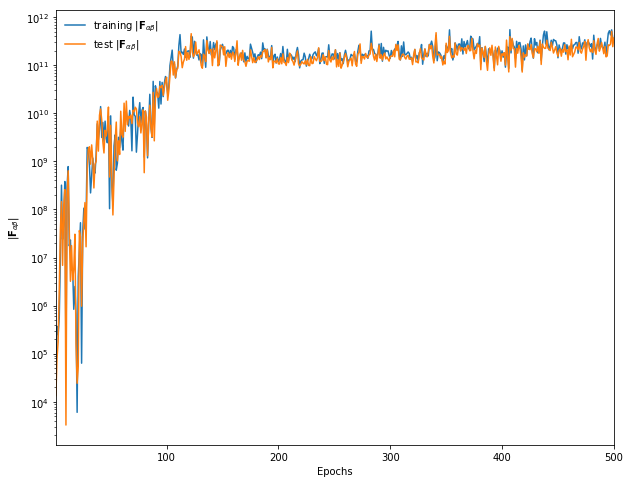

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax.plot(np.arange(1, n_epochs + 1), F, label = r"training $|{\bf F}_{\alpha\beta}|$")
ax.plot(np.arange(1, n_epochs + 1), test_F, label = r"test $|{\bf F}_{\alpha\beta}|$")
ax.legend(frameon = False)
ax.set_yscale('log')
ax.set_xlim([1, n_epochs])
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$|{\bf F}_{\alpha\beta}|$");

In [ ]:
# Data vector
# Simulate some cosmic shear data
data = compressor(simulator(theta_fiducial, simulator_args), compressor_args)

In [ ]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

In [ ]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

Done.


Sampling approximate posterior...


/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/_multivariate.py:462: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(np.dot(dev, prec_U)), axis=-1)


Done.


/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/chains.py:334: RuntimeWarning: overflow encountered in square
  self.vars[i] = self.weights.dot((self.samples[:, i] - self.means[i]) ** 2) / self.norm
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:130: RuntimeWarning: overflow encountered in double_scalars
  auto[0] = xt[0] ** 2
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:131: RuntimeWarning: overflow encountered in double_scalars
  auto[-1] = xt[-1] ** 2
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/convolve.py:132: RuntimeWarning: overflow encountered in square
  auto[1:-1] = (xt[1:-2:2] ** 2 + xt[2:-1:2] ** 2)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/chains.py:488: RuntimeWarning: overflow encountered in square
  return np.dot(self.mean_diff(paramVec) ** 2, self.weights) / self.get_norm()
/Users/charnock/.pyenv/versions

ValueError: cannot convert float NaN to integer

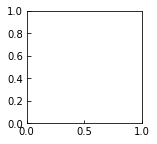

In [16]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()